# BANKING: DIRECT MARKETING CASE STUDY (CAMPAIGN RESPONSE MODEL) - CLASSIFICATION MODEL
OBJECTIVE: This Business problem uses data related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be subscribed ('yes') or not ('no').

### Import Packages

In [1]:
#Packages related to general operating system & warnings 
import warnings
warnings.filterwarnings('ignore')

#Packages related to data importing, manipulation, exploratory data analysis
import numpy as np
import pandas as pd

#Packages related to data visualizaiton
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Modules related to split the data & gridsearch
from sklearn.model_selection import train_test_split

#Module related to calculation of metrics
from sklearn import metrics
from sklearn.metrics import classification_report

# ANN modules
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix

### create UDFs

In [2]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

### Import Data

In [3]:
df=pd.read_csv('bank.csv', sep=";")

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Data Preparation

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [6]:
# Default & pdays droped because of high cardinality, euribor3m, nr.employed dropped because of high correlations with some other variables,
# cons.price.idx is dropeed because of less CV 
df.drop(['default', 'euribor3m', 'nr.employed', 'cons.price.idx', 'pdays'], axis=1, inplace=True)

In [7]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.conf.idx', 'y'],
      dtype='object')

In [8]:
# Handling unknown & 999 values
def missing_value_treat(x):
    if ((x.dtype=='float') or (x.dtype=='int')):
        x[x==999] = np.nan
        x=x.fillna(x.median())
    else:
        x[x=='unknown'] = np.nan
        x=x.fillna(x.mode()[0])
        
    return x  

In [9]:
df = df.apply(missing_value_treat)

In [10]:
# split data to continous and categorical varaiables.
num_var=df.select_dtypes(include=['float64','int64'])
cat_var=df.select_dtypes(['object'])

In [11]:
num_var.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.conf.idx'],
      dtype='object')

In [12]:
cat_var.columns

Index(['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [13]:
num_var.apply(continuous_var_summary)

,age,duration,campaign,previous,emp.var.rate,cons.conf.idx
N,4119.000000,4.119000e+03,4119.000000,4119.000000,4119.000000,4119.000000
NMISS,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
SUM,165228.000000,1.057710e+06,10451.000000,784.000000,350.000000,-166815.800000
MEAN,40.113620,2.567881e+02,2.537266,0.190337,0.084972,-40.499102
MEDIAN,38.000000,1.810000e+02,2.000000,0.000000,1.100000,-41.800000
STD,10.313362,2.547037e+02,2.568159,0.541788,1.563114,4.594578
VAR,106.365426,6.487399e+04,6.595442,0.293535,2.443327,21.110142
MIN,18.000000,0.000000e+00,1.000000,0.000000,-3.400000,-50.800000
P1,24.000000,1.100000e+01,1.000000,0.000000,-3.400000,-50.000000
P5,26.000000,3.500000e+01,1.000000,0.000000,-2.900000,-47.100000


In [14]:
cat_var.describe(include='O')

,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y
count,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
unique,11,3,7,2,2,2,10,5,3,2
top,admin.,married,university.degree,yes,no,cellular,may,thu,nonexistent,no
freq,1051,2520,1431,2280,3454,2652,1378,860,3523,3668


In [15]:
# Outlier treatment
num_var = num_var.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [16]:
num_var.apply(continuous_var_summary)

,age,duration,campaign,previous,emp.var.rate,cons.conf.idx
N,4119.000000,4.119000e+03,4119.000000,4119.000000,4119.000000,4119.000000
NMISS,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
SUM,164980.000000,1.041868e+06,10230.000000,760.000000,350.000000,-166796.600000
MEAN,40.053411,2.529419e+02,2.483613,0.184511,0.084972,-40.494440
MEDIAN,38.000000,1.810000e+02,2.000000,0.000000,1.100000,-41.800000
STD,9.996408,2.306667e+02,2.228488,0.501036,1.563114,4.584517
VAR,99.928181,5.320713e+04,4.966159,0.251037,2.443327,21.017796
MIN,24.000000,1.100000e+01,1.000000,0.000000,-3.400000,-50.000000
P1,24.000000,1.100000e+01,1.000000,0.000000,-3.400000,-50.000000
P5,26.000000,3.500000e+01,1.000000,0.000000,-2.900000,-47.100000


In [17]:
data_final = pd.concat([num_var, cat_var],axis=1)

In [18]:
data_final.head()

,age,duration,campaign,previous,emp.var.rate,cons.conf.idx,job,marital,education,housing,loan,contact,month,day_of_week,poutcome,y
0,30.0,487.0,2.0,0.0,-1.8,-46.2,blue-collar,married,basic.9y,yes,no,cellular,may,fri,nonexistent,no
1,39.0,346.0,4.0,0.0,1.1,-36.4,services,single,high.school,no,no,telephone,may,fri,nonexistent,no
2,25.0,227.0,1.0,0.0,1.4,-41.8,services,married,high.school,yes,no,telephone,jun,wed,nonexistent,no
3,38.0,17.0,3.0,0.0,1.4,-41.8,services,married,basic.9y,yes,no,telephone,jun,fri,nonexistent,no
4,47.0,58.0,1.0,0.0,-0.1,-42.0,admin.,married,university.degree,yes,no,cellular,nov,mon,nonexistent,no


### EDA

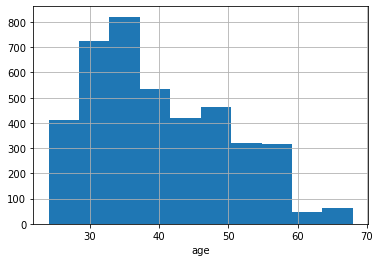

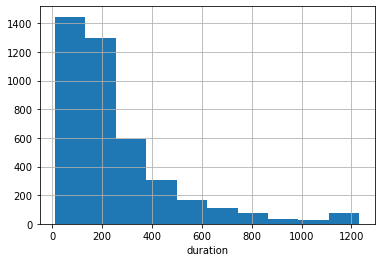

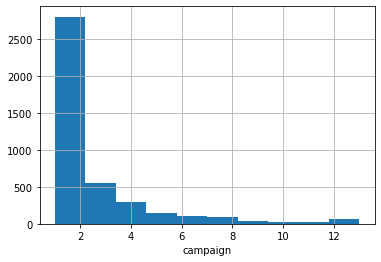

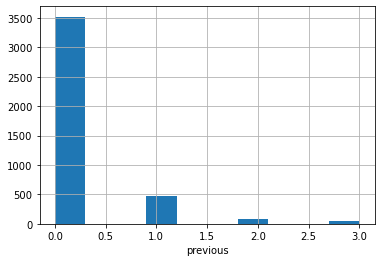

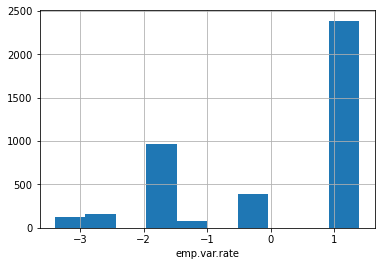

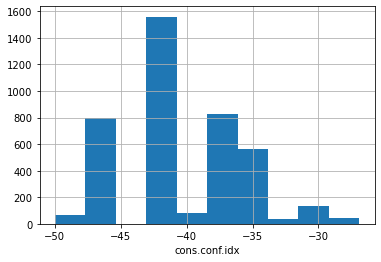

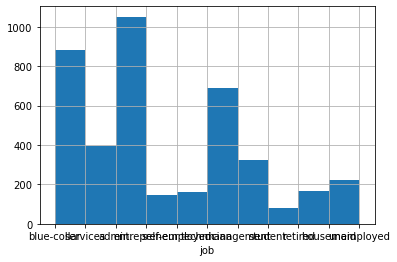

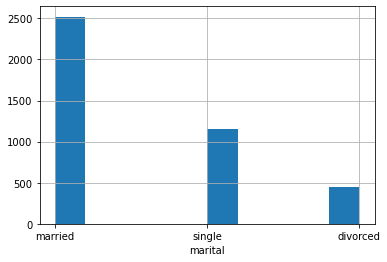

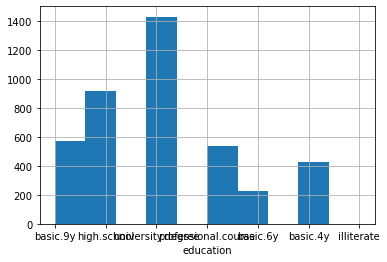

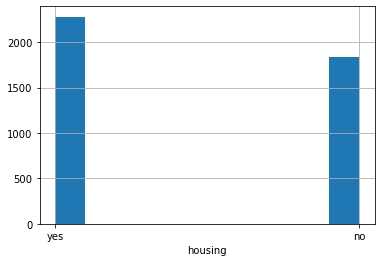

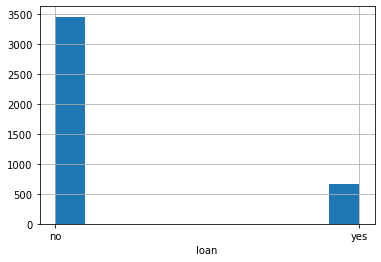

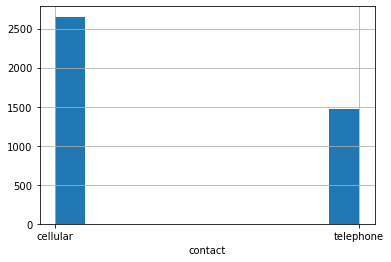

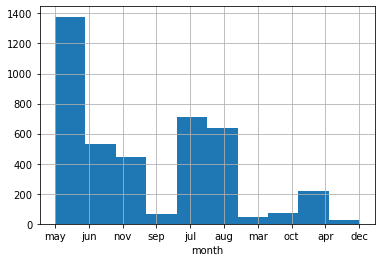

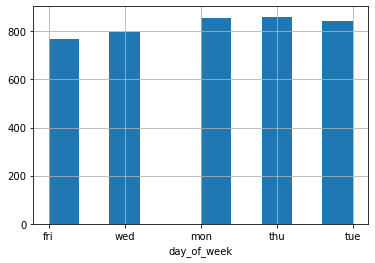

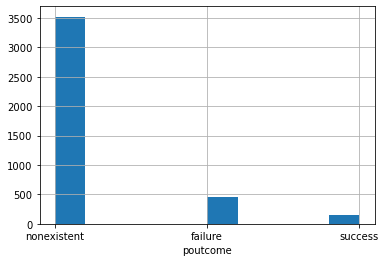

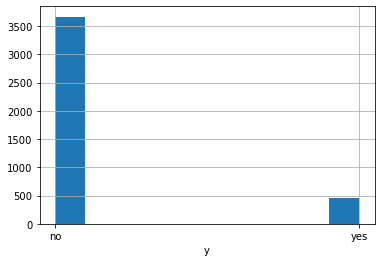

In [19]:
for i in data_final.columns:
    data_final[i].hist()
    plt.xlabel(str(i))
    plt.show()

In [20]:
data_final.y.value_counts(normalize=True)

no     0.890507
yes    0.109493
Name: y, dtype: float64

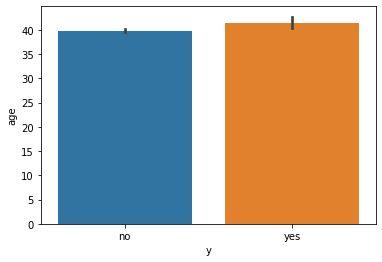

In [21]:
sns.barplot(x='y',y='age',data=data_final)
plt.show()

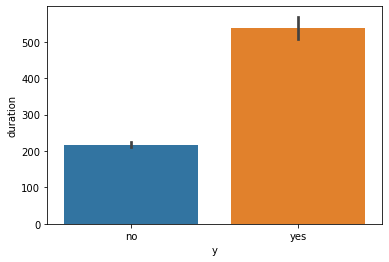

In [22]:
sns.barplot(x='y',y='duration',data=data_final)
plt.show()

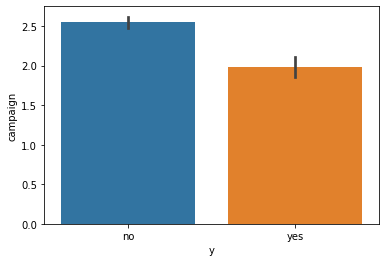

In [23]:
sns.barplot(x='y',y='campaign',data=data_final)
plt.show()

In [24]:
# Insights from above plots

# --> Usually calls duration that exceed 250 seconds consider client approval (note: if duration =0 then y = No).
# --> Average age for clients is 39.
# --> Most clients get contact 2 times in each campaign. 
# --> Most of the clients that are yes in campaign do not have loans
# --> More than 70% clients have a direct call from the bank.
# -->  90% of clients would be subscribed (Yes).

In [25]:
data_final = pd.get_dummies(data_final, columns = cat_var.columns,  drop_first=True)

In [26]:
data_final.head()

,age,duration,campaign,previous,emp.var.rate,cons.conf.idx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success,y_yes
0,30.0,487.0,2.0,0.0,-1.8,-46.2,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,39.0,346.0,4.0,0.0,1.1,-36.4,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,25.0,227.0,1.0,0.0,1.4,-41.8,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,38.0,17.0,3.0,0.0,1.4,-41.8,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,47.0,58.0,1.0,0.0,-0.1,-42.0,0,0,0,0,...,1,0,0,1,0,0,0,1,0,0


In [27]:
data_final.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.conf.idx', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],
      dtype='object')

In [28]:
data_final.columns = [i.replace('.', '_').replace('-', '_') for i in data_final.columns]

In [29]:
data_final.columns

Index(['age', 'duration', 'campaign', 'previous', 'emp_var_rate',
       'cons_conf_idx', 'job_blue_collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self_employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_basic_6y', 'education_basic_9y',
       'education_high_school', 'education_illiterate',
       'education_professional_course', 'education_university_degree',
       'housing_yes', 'loan_yes', 'contact_telephone', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success', 'y_yes'],
      dtype='object')

## Splitting Data

In [30]:
X = data_final[data_final.columns.difference(['y_yes'])]
y = data_final.y_yes

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Apply SMOTE

In [32]:
from imblearn.over_sampling import SMOTE

In [33]:
smote = SMOTE(random_state=123)

In [34]:
x_train_resampled, y_train_resampled = smote.fit_resample(x_train,y_train)

In [36]:
# check class distribution before and after SMOTE
print('Class distribution before SMOTE: ',{cls: sum(y_train == cls) for cls in set(y_train)})
print('Class distribution before SMOTE: ',{cls: sum(y_train_resampled == cls) for cls in set(y_train_resampled)})

Class distribution before SMOTE:  {0: 2576, 1: 307}
Class distribution before SMOTE:  {0: 2576, 1: 2576}


-------------------------------------------------------------------------------------------------------------------------------

##### Standarization

In [37]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train_resampled)
x_test_sc = sc.transform(x_test)

In [38]:
y_train=np.asarray(y_train_resampled)
y_test=np.asarray(y_test)
print(y_test)

[0 0 0 ... 1 0 0]


### ANN

In [39]:
x_train_sc.shape

(5152, 42)

In [40]:
model = Sequential()

In [41]:
model.add(layers.Dense(32,activation='relu',input_shape=(x_train_sc.shape[-1],)))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1376      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

-------------------------------------------------------------------------------------------------------------------------------

In [44]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
)

In [45]:
model_history=model.fit(x_train,y_train,validation_split=0.3,batch_size=10,epochs=100,callbacks=[early_stopping])

Epoch 1/100
202/202 [==============================] - 1s 3ms/step - loss: 0.3912 - accuracy: 0.8831 - val_loss: 0.4938 - val_accuracy: 0.8185
Epoch 2/100
202/202 [==============================] - 0s 2ms/step - loss: 0.3435 - accuracy: 0.8885 - val_loss: 0.2209 - val_accuracy: 0.9052
Epoch 3/100
202/202 [==============================] - 0s 2ms/step - loss: 0.2964 - accuracy: 0.8935 - val_loss: 0.2404 - val_accuracy: 0.8913
Epoch 4/100
202/202 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.8969 - val_loss: 0.2185 - val_accuracy: 0.9075
Epoch 5/100
202/202 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.8930 - val_loss: 0.2347 - val_accuracy: 0.8960
Epoch 6/100
202/202 [==============================] - 0s 2ms/step - loss: 0.2737 - accuracy: 0.8954 - val_loss: 0.2824 - val_accuracy: 0.8879
Epoch 7/100
202/202 [==============================] - 0s 2ms/step - loss: 0.2429 - accuracy: 0.9054 - val_loss: 0.2102 - val_accuracy: 0.9064

In [46]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

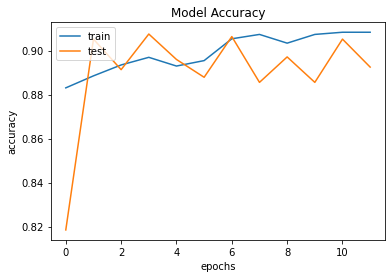

In [47]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

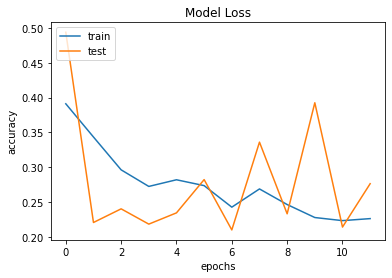

In [48]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [49]:
y_pred=model.predict(x_test)

39/39 [==============================] - 0s 1ms/step


In [50]:
y_pred=(y_pred>=0.5)
y_pred

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      1092
           1       0.69      0.08      0.14       144

    accuracy                           0.89      1236
   macro avg       0.79      0.54      0.54      1236
weighted avg       0.87      0.89      0.85      1236



In [52]:
model.get_weights()

[array([[ 2.54010916e-01, -3.72930877e-02,  1.50461897e-01, ...,
          5.14735207e-02, -1.75117746e-01, -1.32094204e-01],
        [ 9.76577923e-02, -1.28970563e-01, -7.78658018e-02, ...,
         -2.13682633e-02,  3.01722884e-02, -1.89818740e-01],
        [-2.44497845e-04,  8.76089409e-02, -1.80329666e-01, ...,
         -1.94332793e-01,  7.30658770e-02, -9.71264690e-02],
        ...,
        [ 7.43837794e-03, -1.77627146e-01, -2.31618285e-01, ...,
          3.68163854e-01, -4.12616134e-02, -9.60930958e-02],
        [ 3.01334620e-01,  6.54319227e-01,  1.53498963e-01, ...,
         -4.44036782e-01, -1.80303186e-01,  3.29740465e-01],
        [ 3.52632284e-01,  2.28429157e-02,  1.67990744e-01, ...,
          6.18001632e-02,  1.05235666e-01,  2.08481357e-01]], dtype=float32),
 array([-0.05462505, -0.02780659, -0.00082678, -0.00047677,  0.04338443,
         0.        ,  0.0180851 , -0.06756514, -0.04368023, -0.0449924 ,
        -0.04912276, -0.05549265,  0.01509855, -0.00859283, -0.02008